## Homework 3
### Daniel Kuknyo
Solve the problem with
1. Q-learning. Use different constant updates
• 𝛼 values: 0.01, 0.03, 0.1, 0.3
2. Monte Carlo. Use 𝛼𝑡 = 1/𝑡
values
3. SARSA learning. Use epsilon-greedy action selection: 𝜖𝑡 = 1/𝑡
4. Like task 3 but use different eligibilities (SARSA(𝜆))
• 𝜆 values: 0.01, 0.03, 0.1, 0.3
• Figure out SARSA(𝜆).
• Then check: http://incompleteideas.net/book/ebook/node77.html
• Add epsilon-greedy action choice

### Set up environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

random_seed = 6556 #TODO: Write your given random seed here
np.random.seed(random_seed)

In [2]:
# Initalize environment
# DO NOT MODIFY THIS CELL
nr_of_states = 10
nr_of_actions = 3

states = list(range(0,nr_of_states))
actions = list(range(0,nr_of_actions))

# Initialize transition_probability_matrix
transition_probability_matrix = np.zeros((nr_of_states,nr_of_states,nr_of_actions))

for action_id in range(nr_of_actions):
    for i,tpr in enumerate(transition_probability_matrix[:,:,action_id]):
        choosen_indexes = np.random.choice(nr_of_states, 3, replace=False)
        random_probs = np.random.random(3)    
        random_sum = sum(random_probs)
        random_probs = [i/random_sum for i in random_probs]
        
        for j, k in enumerate(choosen_indexes):
            tpr[k] = random_probs[j]

rewards = np.random.randint(0,100,(nr_of_states,nr_of_actions))

In [3]:
# DO NOT MODIFY THIS CELL
def step(state, action):   
    new_state = np.random.choice(nr_of_states, 1, p=transition_probability_matrix[state,:,action])[0]
    reward = rewards[state, action]    
    return new_state, reward

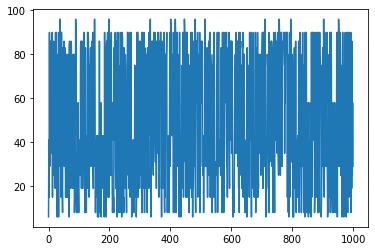

In [4]:
# Simple random trial. We play 1000 episodes and log the reward, then plot it. As you can see the result is also random.
gained_rewards =[]
state = 0
for i in range(1000):
    action = np.random.randint(1,nr_of_actions)
    state, reward = step(state,action)
    gained_rewards.append(reward)

plt.plot(gained_rewards)
plt.show()

### Define plotting functions

In [5]:
# A function to visualize results
def plot_results(results, episodes=1000, metric="episilon"):
    plt.figure(figsize=(10,8))

    for eps in results.keys():
        plt.plot(results[eps], label=metric+"="+str(eps))

    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Iterations", size=12)
    plt.ylabel("Average Reward", size=12)
    plt.title("Average rewards after " + str(episodes) + " Episodes", size=15)
    plt.show()

In [6]:
# Plot a Q_table
def plot_Q_table(Q_table, show=False):
    df = pd.DataFrame(Q_table)
    sns.heatmap(df, annot=True, fmt='g', cmap='viridis')
    if(show):
        plt.show()

In [7]:
# Plot multiple Q-tables
def plot_Q_multi(result, metric="alpha"):
    k = len(result)
    n = np.floor((k+0.5)/2)
    fig = plt.figure(figsize=(12,12))
    fig.suptitle('Visualization of Q-tables', size=15)
    
    for i,alpha in enumerate(result.keys()):
        Q_table = result[alpha]
        ax = fig.add_subplot(2,2,i+1) 
        ax.set_title("Q-table for " + metric + "=" + str(alpha))
        ax = plot_Q_table(Q_table, show=False)
        plt.xlabel("Action")
        plt.ylabel("State")

In [8]:
# Plot a policy
def plot_policy(policy, name):
    print("---- Best policy for " + name + "----")
    for k in policy.keys():
        if(policy[k]==1):
            print(str(k[0]) + " ---> " + str(k[1]))

## Q-Learning  
source: Sutton-Barto - Introduction to Reinforcement Learning

#### Create a Q-table

In [9]:
# Creates a Q table
def get_Q_table(random=True):
    if(random):
        Q_table = abs(np.random.randn(nr_of_states, nr_of_actions) / 2)
    else:
        Q_table = np.zeros((nr_of_states, nr_of_actions))
    return Q_table

### Define the algorithm

In [28]:
# Number of episodes, iterations in episode, step size, exploration probability, transition probability matrix
def run_Q_learning(num_episodes, num_iter_episode, alpha, epsilon, gamma):
    
    #### Tracking variables init ####
    Q_table = get_Q_table(random=True) # Arbitrarily small initial numbers for Q-table - positive
    total_rewards_episode = []
    total_rewards_mean = []
    
    for e in range(num_episodes): # Loop for each episode
        state = 0 # Initialize S
        episode_reward = 0
        
        for i in range(num_iter_episode): # Loop for each step of the episode 
            
            # Decide if the agent is going to explore / exploit
            reward = 0
            p = np.random.rand()
            if(p < epsilon): # Exploration
                action = np.random.randint(1, nr_of_actions) # Choose some random action
                next_state, reward = step(state, action)
            else: # Exploitation
                action = np.argmax(Q_table[state]) # Choose action based on Q_table
                next_state, reward = step(state, action)
            
            Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])
            
            episode_reward += reward 
            state = next_state
        
        total_rewards_episode.append(episode_reward) # Update episodic tracking
        total_rewards_mean.append(sum(total_rewards_episode) / (e+1)) # Update mean tracking
    
    return Q_table, total_rewards_mean

### Run the learning and plot the results

In [29]:
#### Init tracking variables ####
Q_results_table = {}
Q_results_mean = {}

try_alphas = [0.01, 0.03, 0.1, 0.3]

# Let's run the learning with a set of different step sizes
for alpha in try_alphas:
    Q_table, Q_mean_rewards = run_Q_learning(num_episodes=1000,  num_iter_episode=100, alpha=alpha, epsilon=0.2, gamma=0.8)
    
    Q_results_table[alpha] = Q_table
    Q_results_mean[alpha] = Q_mean_rewards

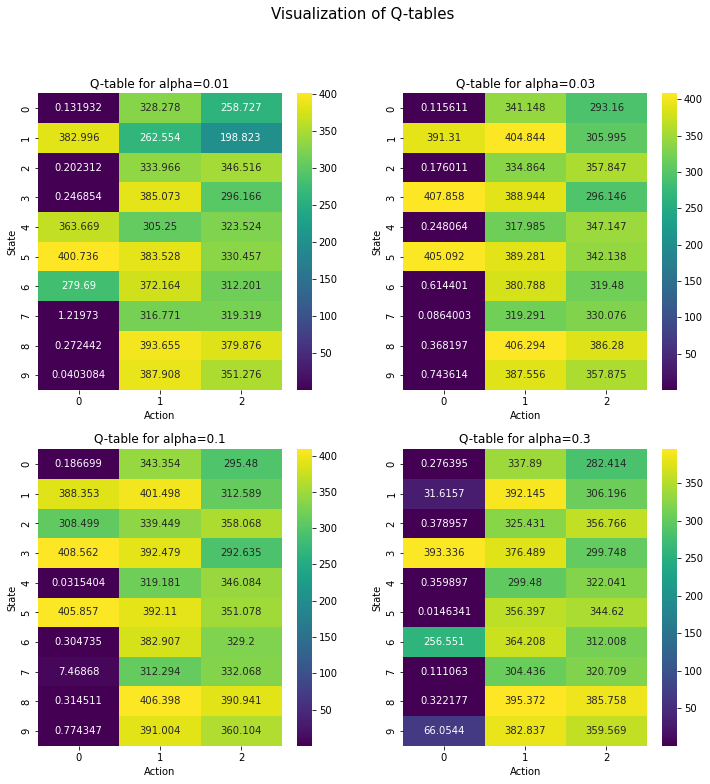

In [30]:
plot_Q_multi(Q_results_table)

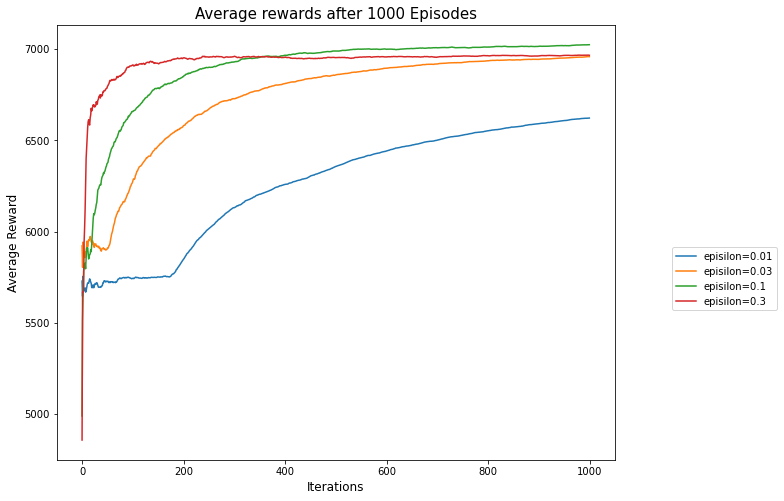

In [31]:
plot_results(Q_results_mean)

## Monte Carlo  
Source: Sutton-Barto: Introduction to Reinforcement Learning  

#### Create a policy
This will also create returns because I was lazy to create a separate method for it

In [14]:
# Creates a policy
def get_random_policy(random=True, returns=False):
    policy = {}
    for s in states:
        ns_rand = [np.random.rand() for i in range(nr_of_actions)]
        ns_s = sum(ns_rand)
        ns_prob = [i/ns_s for i in ns_rand]
        
        for a in actions:
            if(returns):
                policy[(s,a)] = [] # Empty list for all (s,a)
                continue
            if(random):
                policy[(s,a)] = ns_prob[a]
            else:
                policy[(s,a)] = 0
    return policy

def get_greedy_update(policy, state, action): # Update a policy greedily 
    policy[(state, action)] = 1
    for k in policy.keys():
        if(k[0] == state and k[1]!=action): # Set every other action belonging to the state to 0
            policy[(k[0], k[1])] = 0 
    return policy

#### Generate an episode

In [15]:
def generate_episode(policy, num_iter_episode, s0, a0):
    episode_tracks = []
    state = s0
    action = -1
    for i in range(num_iter_episode):
        if(i==0):
            state = s0
            action = a0
        else:
            action_cumsum = np.cumsum([policy[x] for x in policy if x[0]==state])
            p = np.random.rand()
            action = 0
            while(p>action_cumsum[action]):
                action+=1
            
        next_state, reward = step(state, action)
        state = next_state
        episode_tracks.append((state, action, reward))
    return episode_tracks

### Define the algorithm

In [16]:
# Define Monte Carlo
def run_MC(num_episodes, num_iter_episode, gamma):
    #### Init variables #### 
    policy = get_random_policy(random=True) # Create an arbitrary policy
    Q_table = get_Q_table(random=True) # Create an arbitrary Q-table
    returns = get_random_policy(random=False, returns=True) # Create a returns structure
    total_rewards_episode = []
    total_rewards_mean = []
    
    for e in range(num_episodes): # Iterate over the episodes
        s0, a0 = list(policy.keys())[np.random.choice(len(policy.keys()))] # Start random s0, a0
        episode = generate_episode(policy, num_iter_episode, s0, a0) # Generate an episode from s0, a0 --> [(state,action,reward) ...]
        total_rewards_episode.append(sum([x[2] for x in episode]))
        total_rewards_mean.append(sum(x for x in total_rewards_episode) / (e+1)) # Update mean rewards tracking 
        G = 0
        
        for t in range(len(episode)-2, -1, -1): # Iterate over the episode backwards
            visited_pairs = {(ep[0],ep[1]) for ep in episode[:t-1]} # State-action pairs that have been visited up until t from 0
            st = episode[t][0]
            at = episode[t][1]
            rt = episode[t][2]
            G = gamma * G + episode[t+1][2] # Update G
            
            if((st, at) not in visited_pairs):
                alpha = 1/t
                returns[(st, at)].append(G) # Update returns
                Q_table[st, at] = Q_table[st, at] + alpha * (G - Q_table[st, at]) # Update Q-table
                best_action = np.argmax(Q_table[state]) # Select best action according to new Q-table
                policy = get_greedy_update(policy, st, best_action) # Update the current policy greedily
    
    return policy, Q_table, total_rewards_mean

### Run Monte Carlo and plot the results

In [17]:
#### Init tracking variables ####
MC_results_table = {}
MC_results_mean = {}
MC_results_policy = {}

try_gammas = [0.6, 0.7, 0.8, 0.9]

# Let's run the learning with a set of different step sizes
for gamma in try_gammas:
    MC_policy, MC_table, MC_mean = run_MC(1000, 50, gamma)
    
    MC_results_table[gamma] = MC_table
    MC_results_mean[gamma] = MC_mean
    MC_results_policy[gamma] = MC_policy

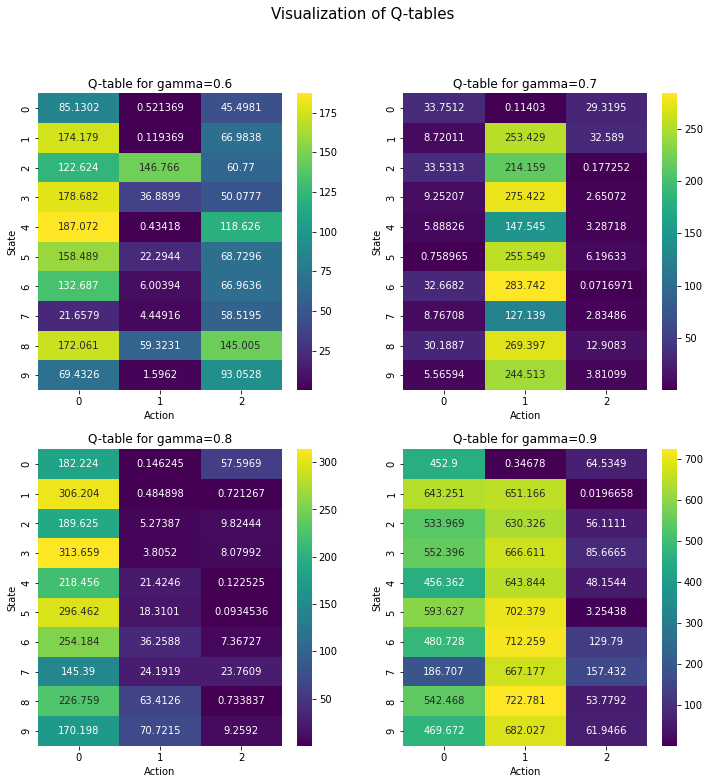

In [18]:
plot_Q_multi(MC_results_table, metric = "gamma")

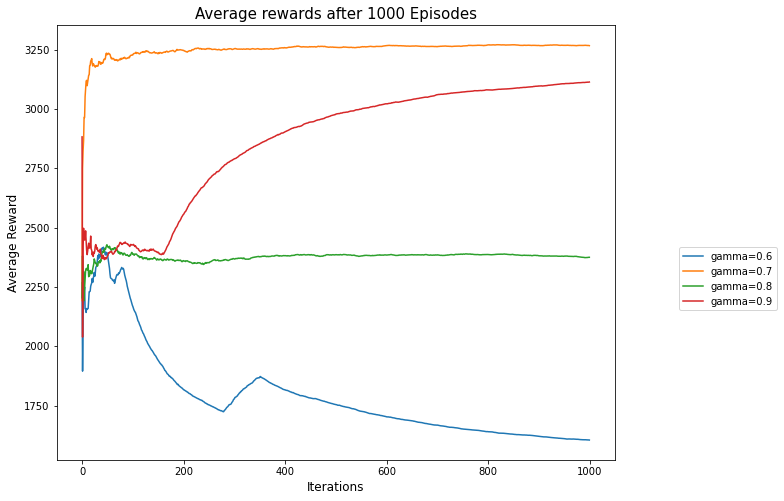

In [19]:
plot_results(MC_results_mean, metric = "gamma")

## SARSA  
Source: Sutton-Barto - Introduction to reinforcement learning
### Define the algorithm

In [22]:
def run_SARSA(num_episodes, num_iter_episode, alpha, gamma):
    Q_table = get_Q_table(random=True) # Initialize Q-table arbitrarily
    total_rewards_episode = []
    total_rewards_mean = []

    for e in range(num_episodes): # Iterate over all the episodes
        episode_reward = 0
        state = np.random.choice(nr_of_states) # Random starting state
        
        # Choose A from S based on Q   
        epsilon = 1/(e+1) # Use epsilon values 1/t
        p = np.random.rand()
        action = -1
        if(p < epsilon):
            action = np.random.randint(1, nr_of_actions)
        else:
            action = np.argmax(Q_table[state])
            
        for i in range(num_iter_episode): # For all steps inside the episode
            # Take action
            next_state, reward = step(state, action)
            
            # Choose A' from S' based on Q
            p = np.random.rand()
            next_action = -1
            if(p < epsilon):
                next_action = np.random.randint(1, nr_of_actions)
            else:
                next_action = np.argmax(Q_table[next_state])
        
            # Update the Q-table based on SARSA update
            Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * Q_table[next_state, next_action] - Q_table[state, action])
            
            state = next_state
            action = next_action
            episode_reward += reward
        
        total_rewards_episode.append(episode_reward)
        total_rewards_mean.append(sum(total_rewards_episode)/(e+1))
        
    return Q_table, total_rewards_mean

### Run the learning and plot the results

In [23]:
SARSA_results_table = {}
SARSA_results_mean = {}

try_alphas = [0.1, 0.15, 0.2, 0.25]

# Let's run the learning with a set of different step sizes
for alpha in try_alphas:
    SARSA_table, SARSA_mean_rewards = run_SARSA(num_episodes=1000,  num_iter_episode=100, alpha=alpha, gamma=0.8)
    
    SARSA_results_table[alpha] = SARSA_table
    SARSA_results_mean[alpha] = SARSA_mean_rewards

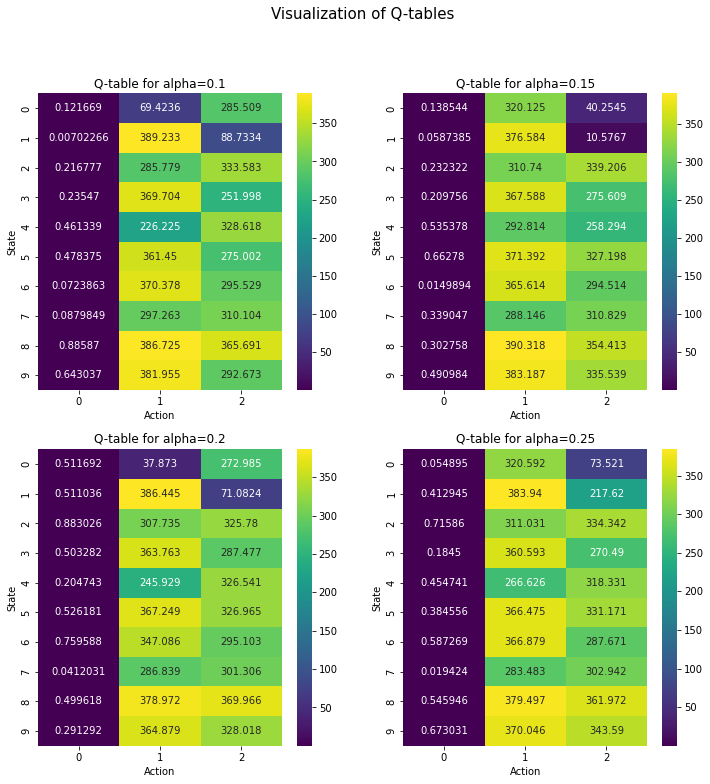

In [24]:
plot_Q_multi(SARSA_results_table, metric = "alpha")

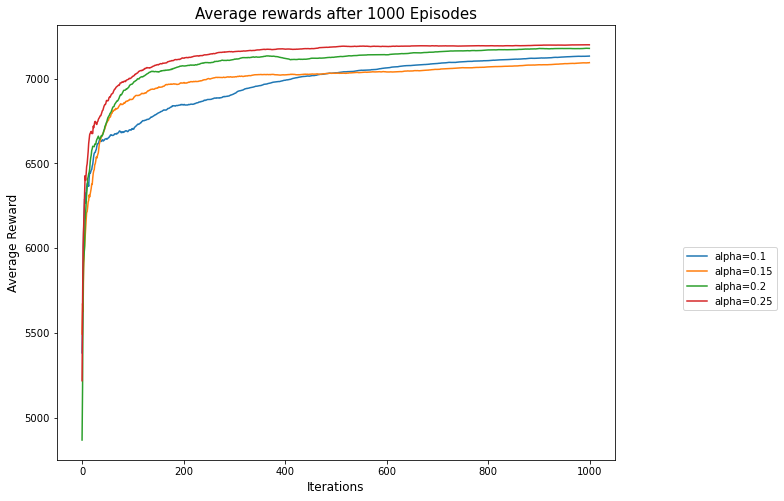

In [25]:
plot_results(SARSA_results_mean, metric = "alpha")

## SARSA(𝜆)  
Source: Sutton-Barto - Introduction to Reinforcement learning [In progress edition]  
### Define the algorithm

In [32]:
def run_SARSA_lambda(num_episodes, num_iter_episode, alpha, gamma, epsilon, lambda_, trace="accumulating"):
    Q_table = get_Q_table(random=True) # Initialize Q-table for all 0
    total_rewards_episode = []
    total_rewards_mean = []
    
    for e in range(num_episodes): # Iterate over each episode
        E_trace = get_Q_table(random=False)
        state = np.random.choice(nr_of_states)
        action = np.random.choice(nr_of_actions)
        episode_reward = 0
        
        for i in range(num_iter_episode): # Iterate over each step of the episode
            next_state, reward = step(state, action)
            episode_reward += reward
            
            # Choose action A' from policy derived from the Q-table
            p = np.random.rand()
            next_action = -1
            if(p < epsilon):
                next_action = np.random.randint(1, nr_of_actions)
            else:
                next_action = np.argmax(Q_table[next_state])
            
            delta = reward + gamma * Q_table[next_state, next_action] - Q_table[state, action] # Update delta value
            
            # This step is based on which kind of trace is selected
            if(trace == "accumulating"):
                E_trace[state, action] = E_trace[state, action] + 1
            elif(trace == "dutch"):
                E_trace[state, action] = (1 - alpha) * E_trace[state, action] + 1
            elif(trace == "replacing"):
                E_trace[state, action] = 1
            else:
                print("Wrong trace selected!")
                break
            
            # Update the eligibility traces and Q-table
            for s in states:
                for a in actions:
                    Q_table[s, a] = Q_table[s, a] + alpha * delta * E_trace[s, a]
                    E_trace[s, a] = gamma * lambda_ * E_trace[s, a]
            
            state = next_state
            action = next_action
        
        total_rewards_episode.append(episode_reward)
        total_rewards_mean.append(sum(total_rewards_episode) / (e+1))

    return Q_table, total_rewards_mean

### Run the learning and plot the results
#### Accumulating traces

In [33]:
SARSA_lambda_results_table = {}
SARSA_lambda_results_mean = {}

try_lambdas = [0.01, 0.03, 0.1, 0.3]

# Let's run the learning with a set of different step sizes
for lambda_ in try_lambdas:
    SARSA_lambda_table, SARSA_lambda_mean_rewards = run_SARSA_lambda(num_episodes=1000,  
                                                                     num_iter_episode=100, 
                                                                     alpha=0.1, 
                                                                     gamma=0.8,
                                                                     epsilon=0.2, 
                                                                     lambda_ = lambda_,
                                                                     trace = "accumulating")
    
    SARSA_lambda_results_table[lambda_] = SARSA_lambda_table
    SARSA_lambda_results_mean[lambda_] = SARSA_lambda_mean_rewards

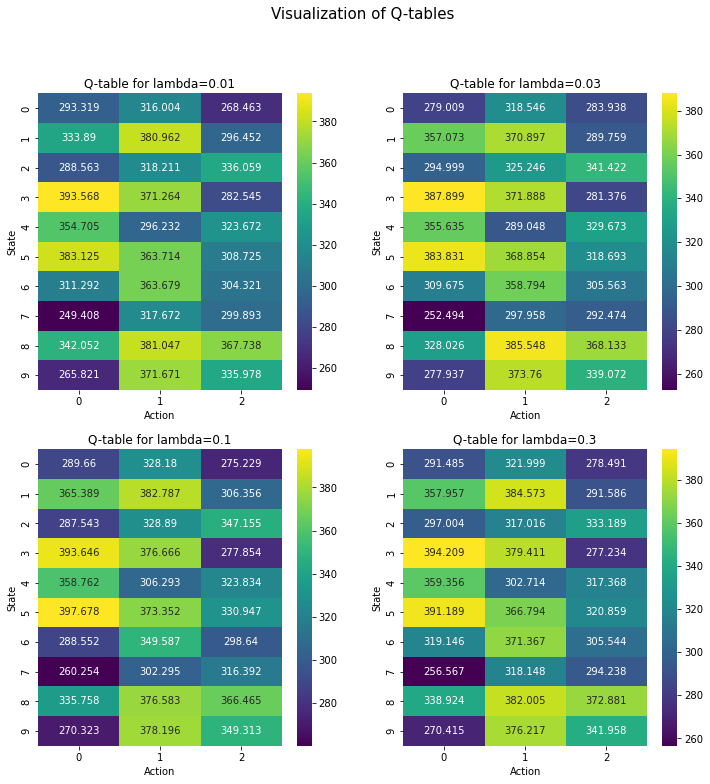

In [34]:
plot_Q_multi(SARSA_lambda_results_table, metric = "lambda")

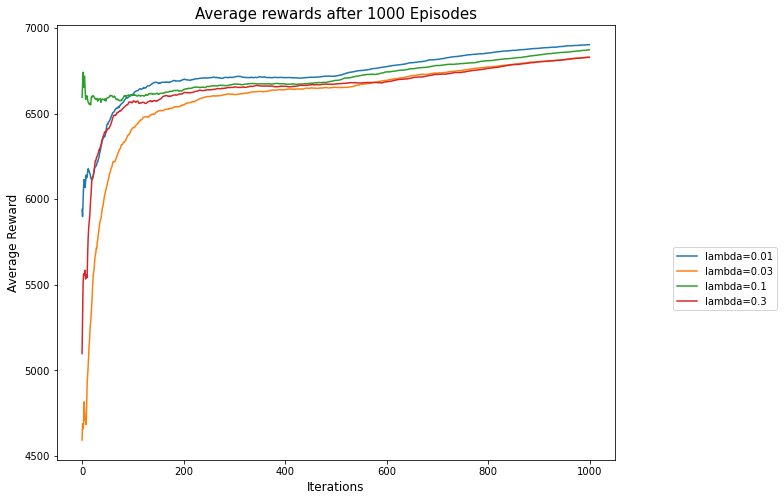

In [35]:
plot_results(SARSA_lambda_results_mean, metric = "lambda")

#### Dutch traces

In [36]:
SARSA_lambda_results_table = {}
SARSA_lambda_results_mean = {}

try_lambdas = [0.01, 0.03, 0.1, 0.3]

# Let's run the learning with a set of different step sizes
for lambda_ in try_lambdas:
    SARSA_lambda_table, SARSA_lambda_mean_rewards = run_SARSA_lambda(num_episodes=1000,  
                                                                     num_iter_episode=100, 
                                                                     alpha=0.1, 
                                                                     gamma=0.8,
                                                                     epsilon=0.2, 
                                                                     lambda_ = lambda_,
                                                                     trace = "dutch")
    
    SARSA_lambda_results_table[lambda_] = SARSA_lambda_table
    SARSA_lambda_results_mean[lambda_] = SARSA_lambda_mean_rewards

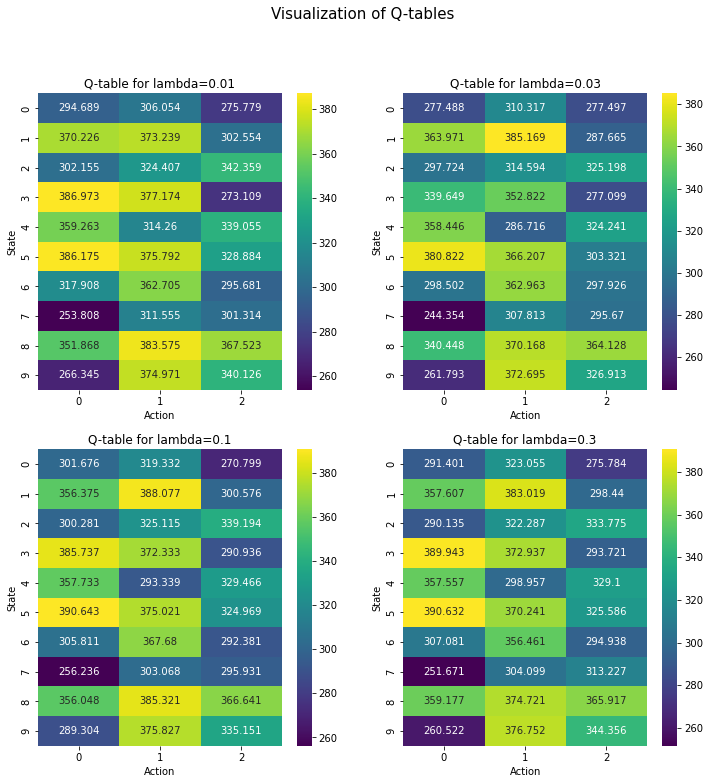

In [37]:
plot_Q_multi(SARSA_lambda_results_table, metric = "lambda")

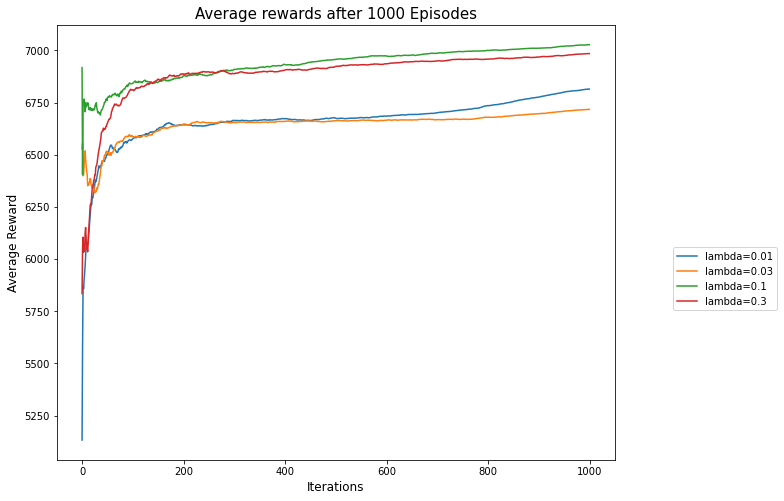

In [38]:
plot_results(SARSA_lambda_results_mean, metric = "lambda")

#### Replacing traces

In [39]:
SARSA_lambda_results_table = {}
SARSA_lambda_results_mean = {}

try_lambdas = [0.01, 0.03, 0.1, 0.3]

# Let's run the learning with a set of different step sizes
for lambda_ in try_lambdas:
    SARSA_lambda_table, SARSA_lambda_mean_rewards = run_SARSA_lambda(num_episodes=1000,  
                                                                     num_iter_episode=100, 
                                                                     alpha=0.1, 
                                                                     gamma=0.8,
                                                                     epsilon=0.2, 
                                                                     lambda_ = lambda_,
                                                                     trace = "accumulating")
    
    SARSA_lambda_results_table[lambda_] = SARSA_lambda_table
    SARSA_lambda_results_mean[lambda_] = SARSA_lambda_mean_rewards

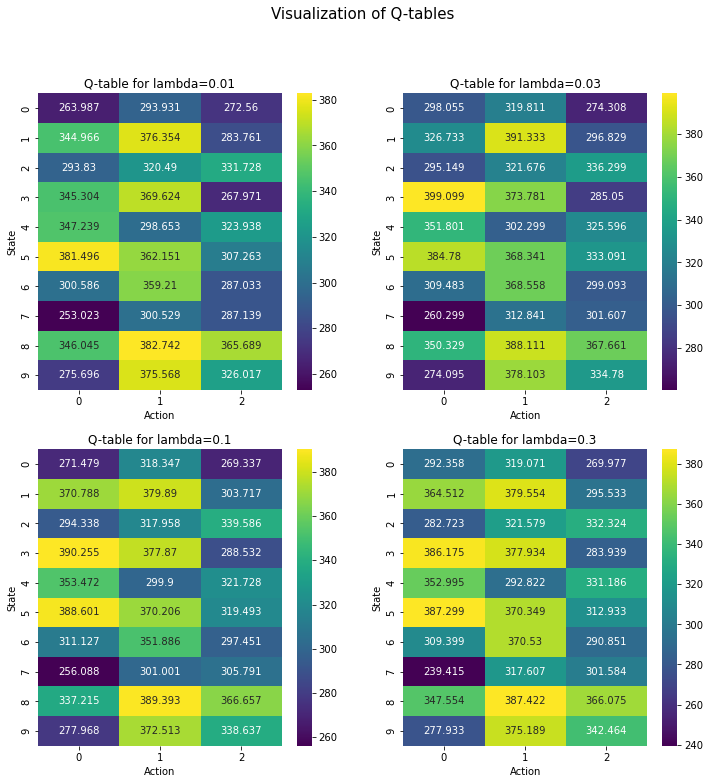

In [40]:
plot_Q_multi(SARSA_lambda_results_table, metric = "lambda")

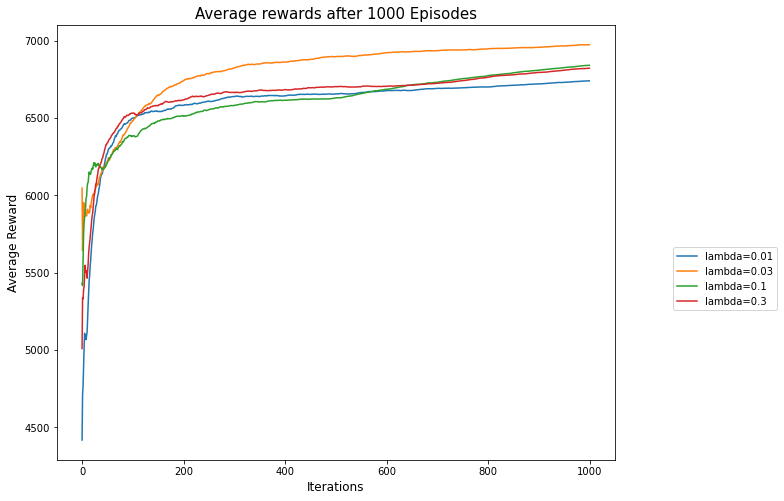

In [41]:
plot_results(SARSA_lambda_results_mean, metric = "lambda")